## EDA on the Yelp Academic Dataset
by Saran Liukasemsarn, Elliot Smalling and Sachin Sridhar

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
import seaborn.apionly as sns
%matplotlib inline
sns.set_context("notebook")

### Acessing the data
First we load the three datasets that were downloaded as json files from Yelp's website. Since we are only concerned with restaurants (not stores, barbers, etc.) we filter the business dataset to include only restaurants, and then use the unique business ids to filter the other datasets appropriately. The "review" dataset was extremely large, so we had to use a different tactic and did not load the text of the reviews, as that was the reason for the large file size.

In [2]:
path = "/Users/eesmalling/Data/project121/"
bns = pd.read_json(path+"business.json", lines=True)
bns = bns[bns.categories.apply(lambda x: 'Restaurants' in x)]
idb = np.array(bns.business_id.unique())
bns.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'neighborhood',
       'postal_code', 'review_count', 'stars', 'state'],
      dtype='object')

In [3]:
data = []
with open(path+"review.json") as f:
    for line in f:
        data.append(json.loads(line))
b = [d['business_id'] for d in data]
r = [d['date'] for d in data]
s = [d['stars'] for d in data]
u = [d['user_id'] for d in data]
rvw = pd.DataFrame(dict(business_id = b, date = r, stars = s, user_id = u))
rvw = rvw[rvw.business_id.isin(idb)]
idu = np.array(rvw.user_id.unique())
rvw.columns

Index(['business_id', 'date', 'stars', 'user_id'], dtype='object')

In [4]:
usr = pd.read_json(path+"user.json", lines=True)
usr = usr[usr.user_id.isin(idu)]
usr.columns

Index(['average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool',
       'elite', 'fans', 'friends', 'funny', 'name', 'review_count', 'useful',
       'user_id', 'yelping_since'],
      dtype='object')

### Filtering the data
Given how difficult the data was to load, we knew that we had to filter it in some way or narrow our scope. We see below that the restaurants are located in disparate states/regions, with Ontario making of the highest number, followed by Arizona.

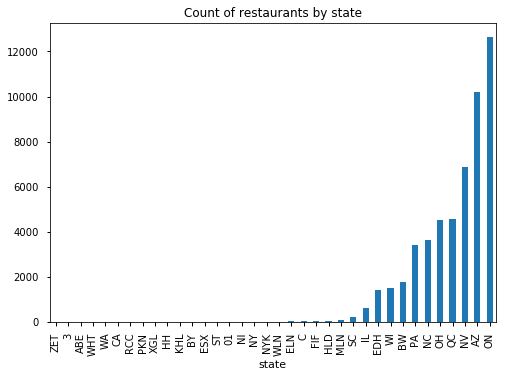

In [5]:
bns.groupby(['state']).size().sort_values().plot.bar()
plt.title('Count of restaurants by state');

We also see that some restaurants were reviewed several thousand times, but a majority had low review counts

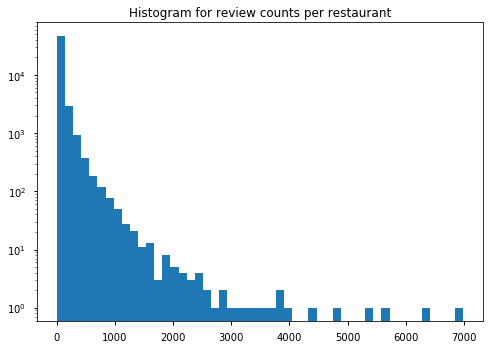

In [6]:
plt.hist(bns['review_count'], bins = 50)
plt.yscale('log')
plt.title('Histogram for review counts per restaurant');

In [7]:
# by restaurant
thresh = [1,3,5,10,100,1000]
prop = [np.mean(bns.review_count<=i) for i in thresh]
pd.DataFrame(dict(max_reviews = thresh, pct_total = prop))

,max_reviews,pct_total
0,1,0.000000
1,3,0.079379
2,5,0.192529
3,10,0.360452
4,100,0.863465
5,1000,0.996939


The users themselves also had varying levels of activity on Yelp: some had writtenh thousands of reviews, but a majority have written ten or less.

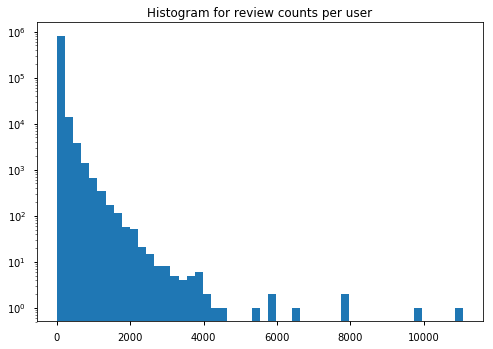

In [8]:
plt.hist(usr['review_count'], bins = 50)
plt.yscale('log')
plt.title('Histogram for review counts per user');

In [9]:
# by user
thresh = [1,3,5,10,100,1000]
prop = [np.mean(usr.review_count<=i) for i in thresh]
pd.DataFrame(dict(max_reviews = thresh, pct_total = prop))

,max_reviews,pct_total
0,1,0.127407
1,3,0.317078
2,5,0.440078
3,10,0.606470
4,100,0.936917
5,1000,0.998664


In the table below we attempt to quantify how sparse a matrix would be if we limited our analysis to certain regions. mx_size represents the total number of reviews if every user reviewed every restaurant in the region, and stars represents the actual number of review written. mx_coverage is the ratio of the two, representing how filled in the matrix would be. We see that using all of the data would result in a very sparse matrix, but less sparsity means fewer reviews to train on.

In [12]:
cvg = rvw.merge(bns[['business_id','state']], how='left')
cvg_u = cvg.groupby('state')['user_id'].nunique().reset_index()
cvg_b = cvg.groupby('state')['business_id'].nunique().reset_index()
cvg_s = cvg.groupby('state')['stars'].count().reset_index()
cvg_all = pd.DataFrame(cvg_u).merge(pd.DataFrame(cvg_b), how='left').merge(pd.DataFrame(cvg_s), how='left')
cvg_all['mx_size'] = cvg_all.user_id*cvg_all.business_id
cvg_all['mx_coverage'] = round(cvg_all.stars/cvg_all.mx_size,6)
cvg_cols = cvg_all.columns
def state_mx(states, label):
    temp = cvg[cvg.state.isin(states)]
    row = pd.DataFrame(dict(state = label,
                            user_id = temp.user_id.nunique(),
                            business_id = temp.business_id.nunique(),
                            stars = len(temp)), index = np.ones(1))
    row['mx_size'] = row.user_id*row.business_id
    row['mx_coverage'] = row.stars/row.mx_size
    return row
cvg_all = cvg_all.append(state_mx(['IL','WI'], 'IL+WI'))
cvg_all = cvg_all.append(state_mx(['ON','QC'], 'ON+QC'))
cvg_all = cvg_all.append(state_mx(['AZ','NV'], 'AZ+NV'))
cvg_all = cvg_all.append(state_mx(['NC','SC'], 'NC+SC'))
cvg_all = cvg_all.append(state_mx(cvg.state.unique(), 'ALL STATES'))
cvg_all = cvg_all.sort_values('mx_coverage')[cvg_cols].reset_index().drop('index', axis=1)

In [14]:
cvg_all

,state,user_id,business_id,stars,mx_size,mx_coverage
0,ALL STATES,823317,51613,2927731,42493860321,0.000069
1,AZ+NV,539224,17102,1787140,9221808848,0.000194
2,ON+QC,113331,17201,513411,1949406531,0.000263
3,AZ,232460,10219,837240,2375508740,0.000352
4,ON,85786,12634,414444,1083820324,0.000382
5,NV,326162,6883,949900,2244973046,0.000423
6,QC,32684,4567,98967,149267828,0.000663
7,OH,49062,4513,154764,221416806,0.000699
8,NC+SC,58213,3826,186600,222722938,0.000838
9,NC,56923,3625,180619,206345875,0.000875


At this point, we have decided to narrow our focus to ON and QC in Canada, as it has a large volume of reviews, but less sparsity than other regions. We export the Canada data to csv files to avoid the time consuming process of loading the json files.

In [18]:
# canada filters
bns = bns[bns.state.isin(['ON','QC'])]
idb = np.array(c_bns.business_id)
rvw = rvw[rvw.business_id.isin(idb)]
idu = np.array(c_rvw.user_id.unique())
usr = usr[usr.user_id.isin(idu)]
#bns.to_csv("c_business.csv")
#usr.to_csv("c_user.csv")
#rvw.to_csv("c_review.csv")

### Exploring the Canada data
We see below that the median star rating in each city is largely aligned, though there is some variation that could have predictive power.

In [16]:
#path = "/Users/eesmalling/Data/project121/"
#bns = pd.read_csv(path+"c_business.csv")
#usr = pd.read_csv(path+"c_user.csv")
#rvw = pd.read_csv(path+"c_review.csv")

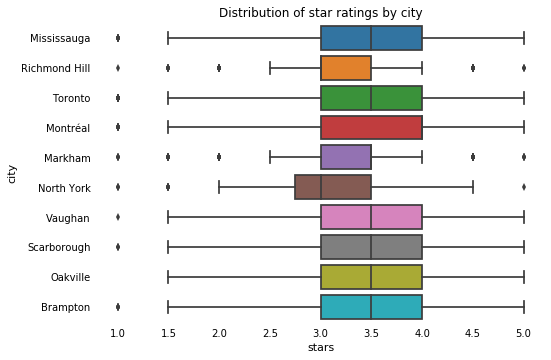

In [10]:
top = np.array(bns.city.value_counts()[0:10].index)
temp = bns[bns.city.isin(top)]
sns.boxplot(y='city', x='stars', data=temp)
ax = plt.gca()
ax.tick_params(axis='both', which='both', length=0)
plt.title('Distribution of star ratings by city')
sns.despine(left=True, bottom=True)

In [11]:
top_category = []
for i in range(len(bns.categories)):
    if len(bns.categories.iloc[i]) == 1:
        top_category.append(bns.categories.iloc[i][0])
    else:
        if bns.categories.iloc[i][0] == 'Restaurants':
            top_category.append(bns.categories.iloc[i][1])
        else:
            top_category.append(bns.categories.iloc[i][0])
bns['top_category'] = top_category

Similarly, the cuisines of the restaurants have similar star rating distributions, but there is still some variation (particularly for burgers and fast food)

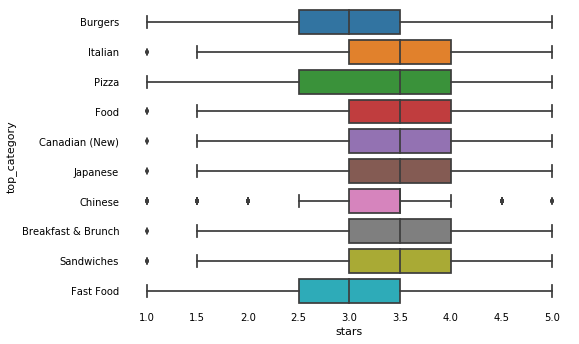

In [12]:
top = np.array(bns.top_category.value_counts()[0:10].index)
temp = bns[bns.top_category.isin(top)]
sns.boxplot(y='top_category', x='stars', data=temp)
ax = plt.gca()
ax.tick_params(axis='both', which='both', length=0)
sns.despine(left=True, bottom=True)

In [17]:
usr.yelping_since = pd.to_datetime(usr.yelping_since)
rvw.date = pd.to_datetime(rvw.date)
rvw['day'] = rvw.date.dt.weekday_name
rvw['month'] = rvw.date.dt.strftime('%B')
rvw = rvw.merge(usr[['user_id','yelping_since']], how='left')
rvw['time_yelping'] = (rvw.date-rvw.yelping_since).dt.days
rvw.time_yelping[rvw.time_yelping < 1] = 1
rvw['log_time_yelping'] = np.log(rvw.time_yelping)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The distributions of star ratings by day they were rated are very similar, though their means show some variation.

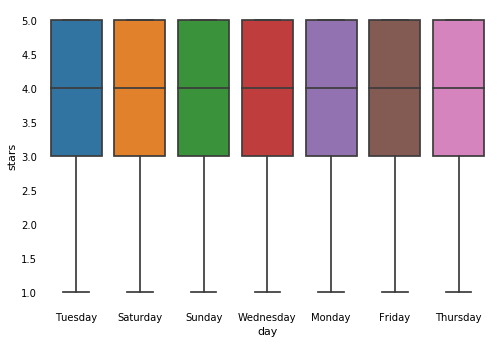

In [18]:
sns.boxplot(y='stars', x='day', data=rvw)
ax = plt.gca()
ax.tick_params(axis='both', which='both', length=0)
sns.despine(left=True, bottom=True)

In [19]:
pd.DataFrame(rvw.groupby('day')['stars'].mean().round(3)).transpose()

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
stars,3.616,3.586,3.589,3.558,3.622,3.615,3.629


The case is the same for month in which the restaurant was rated.

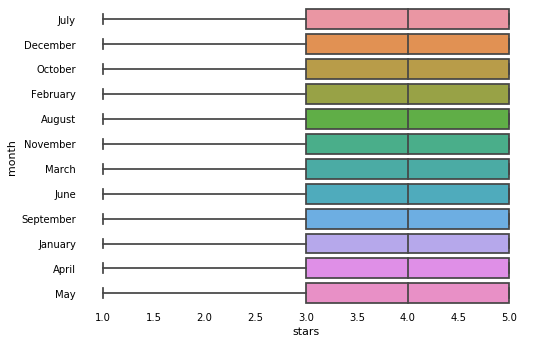

In [20]:
sns.boxplot(y='month', x='stars', data=rvw)
ax = plt.gca()
ax.tick_params(axis='both', which='both', length=0)
sns.despine(left=True, bottom=True)

In [21]:
pd.DataFrame(rvw.groupby('month')['stars'].mean().round(3)).transpose()

month,April,August,December,February,January,July,June,March,May,November,October,September
stars,3.62,3.595,3.582,3.619,3.621,3.588,3.598,3.619,3.595,3.584,3.594,3.582


Here we see that users that have been active on Yelp the longest give more moderate reviews than those who are newer to Yelp

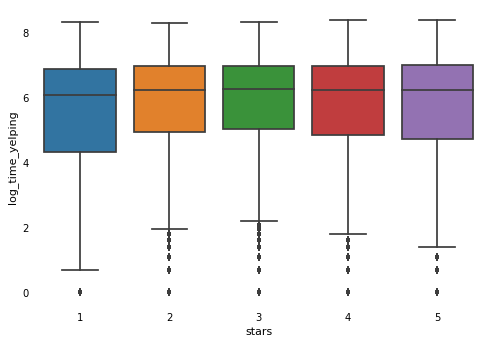

In [22]:
sns.boxplot(y='log_time_yelping', x='stars', data=rvw)
ax = plt.gca()
ax.tick_params(axis='both', which='both', length=0)
sns.despine(left=True, bottom=True)

In [23]:
pd.DataFrame(rvw.groupby('stars')['log_time_yelping'].mean().round(3)).transpose()

stars,1,2,3,4,5
log_time_yelping,5.133,5.526,5.634,5.523,5.425
